In [29]:
from matplotlib import rcParams
import torch
from typing import Any, List, Sequence, Union
import yaml

# Local imports
from Utils.Types.Grid import construct_grid, Grid
from Utils.Types.DataSet import DataSet
from Utils.functions import evaluate_test_funcs, f, integrate, u, test_function
import Utils.plots as plots
from Utils.utils import validate_cfg
from Utils.VPINN import VPINN

In [30]:
# Specify device used to train. Default is the gpu, but torch falls back on the cpu in case cuda is unavailable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
# Load config file
with open('config.yml', 'r') as file:
    cfg = yaml.safe_load(file)

In [32]:
# Validate the configuration to prevent cryptic errors
validate_cfg(cfg)

# Get space parameters from the config
dim: int = cfg['space']['dimension']
eq_type: str = cfg['PDE']['type']
var_form: int = cfg['variational_form']
grid_size: Union[int, Sequence[int]] = cfg['space']['grid_size']['x'] if dim == 1 else [cfg['space']['grid_size']['x'], cfg['space']['grid_size']['y']]
grid_boundary: Sequence = cfg['space']['boundary']['x'] if dim == 1 else [cfg['space']['boundary']['x'], cfg['space']['boundary']['y']]

# Get the neural net architecture from the config
n_nodes: int = cfg['architecture']['nodes_per_layer']
n_layers: int = cfg['architecture']['layers']
architecture: Union[List[int], Any] = [dim] + [n_nodes] * (n_layers+1) + [1]

# Get PDE constants from the config
PDE_constants: dict = {'Helmholtz': cfg['PDE']['Helmholtz']['k'],
                       'Burger': cfg['PDE']['Burger']['nu']}

# Get number of test functions in each dimension
test_func_dim: Union[int, Sequence[int]] = cfg['N_test_functions']['x'] if dim == 1 else [
    cfg['N_test_functions']['x'], cfg['N_test_functions']['y']]
n_test_funcs: int = test_func_dim if dim == 1 else test_func_dim[0]*test_func_dim[1]

In [33]:
# Construct the grid
print("Constructing grid ...")
grid: Grid = construct_grid(dim, grid_boundary, grid_size, as_tensor=True, requires_grad=False)

Constructing grid ...


In [34]:
# Evaluate the test functions on grid points.
print("Evaluating test functions on the grid interior ... ")
test_func_vals, idx = evaluate_test_funcs(grid, test_func_dim)

Evaluating test functions on the grid interior ... 


In [35]:
# Integrate the external function over the grid against all the test functions.
# This will be used to calculate the variational loss; this step is costly and only needs to be done once.

print("Integrating test functions ...")
f_integrated: DataSet = DataSet(coords=idx,
                                data=[integrate(f(grid.interior), test_func_vals[i])
                                      for i in range(n_test_funcs)], as_tensor=True, requires_grad=False)

Integrating test functions ...


In [36]:
# Instantiate the model class
model: VPINN = VPINN(architecture, eq_type, var_form,
                     pde_constants=PDE_constants,
                     learning_rate=cfg['learning_rate'],
                     activation_func=torch.sin).to(device)

In [37]:
# Turn on tracking for the grid
# Note: this actually only needs to happen for the domain of integration (in our case the interior)
grid.data.requires_grad = True
grid.interior.requires_grad = True
grid.boundary.requires_grad = True

In [38]:
# Prepare the training data. The training data consists of the explicit solution of the function on the boundary
print("Generating training data ...")
training_data: DataSet = DataSet(coords=grid.boundary, data=u(grid.boundary), as_tensor=True, requires_grad=False)

Generating training data ...


In [39]:
# Train the model
print("Commencing training ...")
loss_w: float = cfg['loss_weight']
model.reset_loss_tracker()
for it in range(cfg['N_iterations']+1):

    model.optimizer.zero_grad()

    # Calculate the loss
    loss_b = model.boundary_loss(training_data)
    loss_v = model.variational_loss(grid, f_integrated, test_func_vals)
    loss = loss_b + loss_w * loss_v
    loss.backward(retain_graph=True)

    # Adjust the model parameters
    model.optimizer.step()

    # Track loss values
    loss_glob, loss_b_glob, loss_v_glob = loss.item(), loss_b.item(), loss_v.item()

    if it % 10 == 0:
        model.update_loss_tracker(it, loss_glob, loss_b_glob, loss_v_glob)
    if it % 100 == 0:
        print(f"Iteration {it}/{cfg['N_iterations']}: total loss: {loss_glob}, loss_b: {loss_b_glob}, loss_v: {loss_v_glob}")

print("Training complete.")

Commencing training ...
Iteration 0/5000: total loss: 3.625835418701172, loss_b: 0.12980163097381592, loss_v: 0.3496033847332001
Iteration 100/5000: total loss: 3.337125778198242, loss_b: 0.010760998353362083, loss_v: 0.3326364755630493
Iteration 200/5000: total loss: 0.9662344455718994, loss_b: 0.2825508117675781, loss_v: 0.06836836040019989
Iteration 300/5000: total loss: 0.27357926964759827, loss_b: 0.13194963335990906, loss_v: 0.014162964187562466
Iteration 400/5000: total loss: 0.06791549921035767, loss_b: 0.017344506457448006, loss_v: 0.005057099275290966
Iteration 500/5000: total loss: 0.034209560602903366, loss_b: 0.007447333540767431, loss_v: 0.0026762227062135935
Iteration 600/5000: total loss: 0.021067645400762558, loss_b: 0.00531348679214716, loss_v: 0.0015754157211631536
Iteration 700/5000: total loss: 0.014959869906306267, loss_b: 0.004549084696918726, loss_v: 0.0010410785907879472
Iteration 800/5000: total loss: 0.011838162317872047, loss_b: 0.004146651830524206, loss_v:

In [40]:
# Plot the results
rcParams.update(cfg['plots']['rcParams'])

# Generate the plot grid, which may be finer than the training grid
plot_res = cfg['plots']['plot_resolution']['x'] if dim == 1 else [cfg['plots']['plot_resolution']['x'], cfg['plots']['plot_resolution']['y']]
plot_grid: Grid = construct_grid(dim, grid_boundary, plot_res, requires_grad=False)
    
 # Get the model predictions on the plotting grid. Turn off tracking for the prediction data.
predictions = model.forward(plot_grid.data).detach()

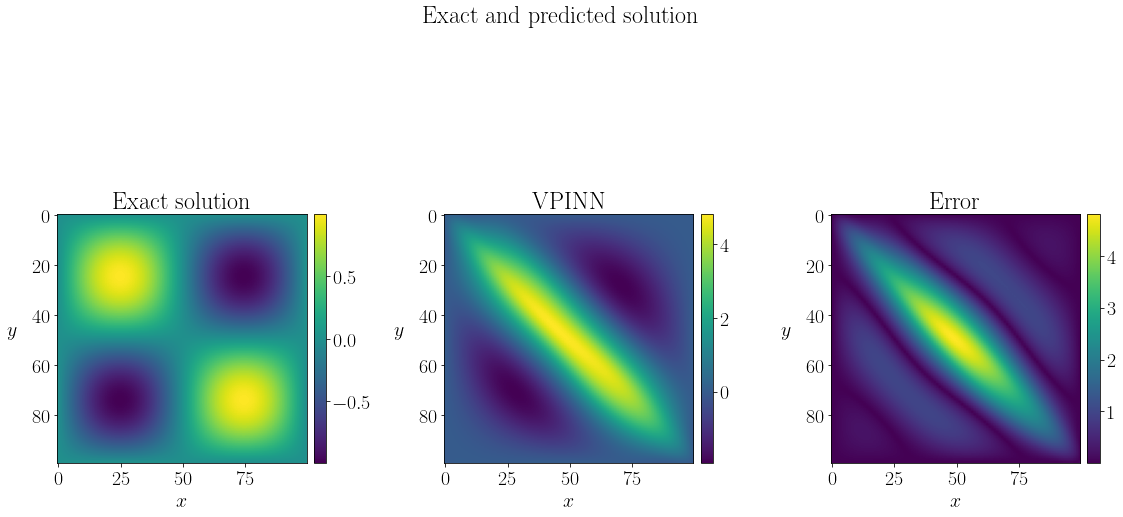

In [41]:
# Plot predicted vs actual values
plots.plot_prediction(plot_grid, predictions, grid_shape=plot_res)

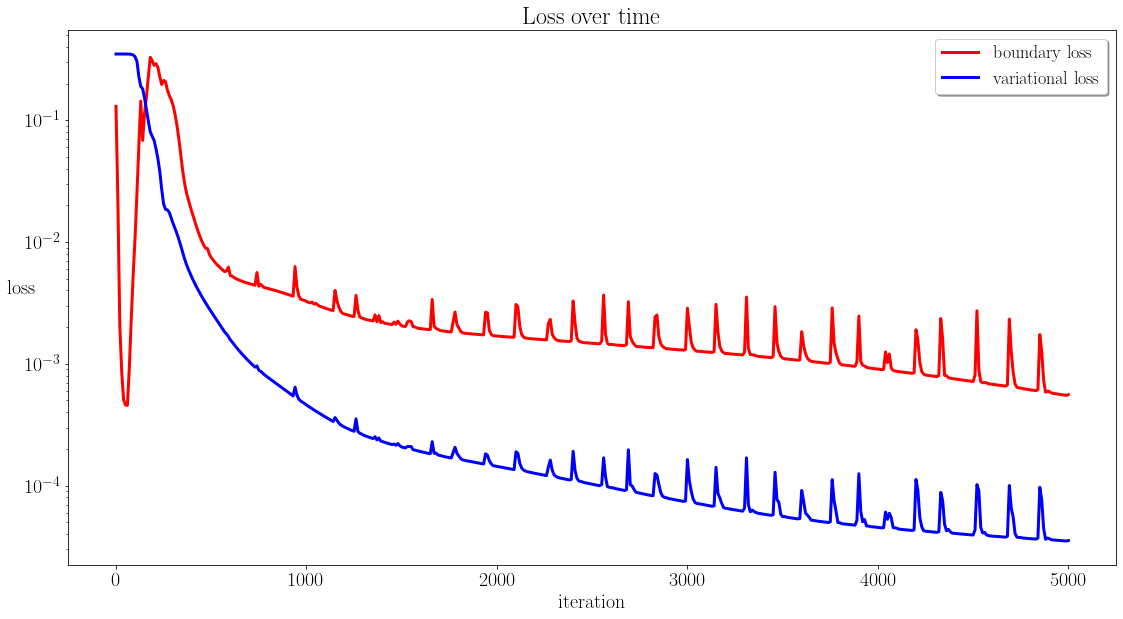

In [42]:
# Plot loss over time
plots.plot_loss(model.loss_tracker)